Ce document contient une implémentation (inâchevée) de l'heuristique résolvant un problème de tournée de véhicules selon les méthodes choisies.

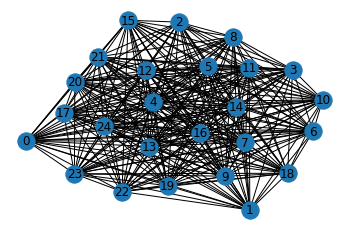

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx
import math
import random

random.seed()

%matplotlib inline

# Création du graphe
graph = nx.Graph()

# Ajout des noeuds
for i in range(25):
    graph.add_node(i)
    
# Ajout des côtés (avec leur coûts)
for n in graph.nodes:
    for m in graph.nodes:
        if n == m:
            continue
        graph.add_edge(n, m, weight=random.uniform(0.5, 4.0))
        
# Positionnement du layout
pos = nx.spring_layout(graph)

# Dessin du graphe
nx.draw_networkx_nodes(graph, pos)
nx.draw_networkx_edges(graph, pos)
nx.draw_networkx_labels(graph, pos)

plt.axis('off')
plt.show()

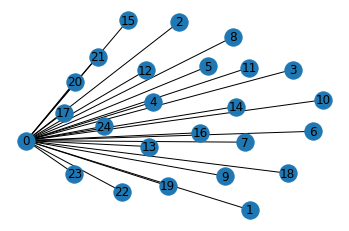

In [2]:
import copy

# On créé une copie du graphe
init = copy.deepcopy(graph)
init.remove_edges_from(list(init.edges))

# Création de la solution initiale
start = 0
for n in init.nodes:
    if n == start:
        continue
    init.add_edge(start, n, weight=graph.edges[(start, n)]['weight'])
    
# Dessin du graphe
nx.draw_networkx_nodes(init, pos)
nx.draw_networkx_edges(init, pos)
nx.draw_networkx_labels(init, pos)

plt.axis('off')
plt.show()

In [ ]:
import operator

# Algorithme de Clake & Wright
a = 1.0
u = 1.0
v = 1.0

# On créé une copie du graphe
sol = copy.deepcopy(init)

# Définition de la fonction qui calcule le "saving"
def saving(i, j):
    ci0 = 0.0 if start == i else graph.edges[(start, i)]['weight']
    cj0 = 0.0 if start == j else graph.edges[(start, j)]['weight']
    cij = graph.edges[(i, j)]['weight']
    
    return (ci0 + cj0 - a * cij + u * abs(ci0 - cj0))

# Définition de la fonction qui va déterminer la route à laquelle appartient une arête
def findRoute(c, i, route):
    node = c
    for e in sol.edges:
        if node in e:
            if e in route:
                continue
            route.append(e)
            if node == e[0]:
                return findRoute(e[1], i, route)
            else:
                return findRoute(e[0], i, route)
    return route

# On calcule le "saving" de toutes les arêtes
savings = {}
for e in init.edges:
    savings[e] = saving(e[0], e[1])
    
# On détermine le saving maximal
saving_max = max(savings.items(), key=operator.itemgetter(1))[0]
while savings[saving_max] > 0.0:
    ri = findRoute(start, saving_max[0], [])
    rj = findRoute(start, saving_max[1], [])